In [1]:
library(igraph)
library(tidyverse)
library(ggplot2)
library(RColorBrewer)
library(rgl)
library(compiler)


Attaching package: ‘igraph’


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.0     ✔ dplyr   1.1.0
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::as_data_frame() masks tibble::as_data_frame(), igraph::as_data_frame()
✖ purrr::compose()       masks igraph::compose()
✖ tidyr::crossing()      masks igraph::crossing()
✖ dplyr::filter()        masks stats::filter()
✖ purrr::flatten()       masks jsonlite::flatten()
✖ dplyr::lag()           masks 

In [2]:
survived <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(V(g)$load, decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived <- cmpfun(survived)

survived_deg <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- order(degree(g), decreasing = TRUE)[1]

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_deg <- cmpfun(survived_deg)

survived_random <- function(g, alpha) {
    V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
    V(g)$capacity <- (1 + alpha) * V(g)$load
    overloaded <- sample(x = 1:length(g), size = 1)

    g_or <- g

    while (length(overloaded) > 0) {
        g_or <- delete_vertices(g_or, overloaded)
        V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
        overloaded <- as.vector(V(g_or)[load > capacity])
    }


    n_prime <- max(components(g_or)$csize)
    n_orig <- max(components(g)$csize)

    return(n_prime/n_orig)
}
survived_random <- cmpfun(survived_random)

In [3]:
mypal <- rev(colorRampPalette(rev(c(brewer.pal(9, "OrRd"))))(20))
# plot(1, 1, type = "n", xlim = c(1, length(mypal)), ylim = c(1, 2), xlab = "", ylab = "")
# for (i in 1:length(mypal)) {
#   rect(i - 0.5, 1, i + 0.5, 2, col = mypal[i])
# }
# legend("topright", legend = mypal, fill = mypal, bg = "white")

In [4]:
nodes <- read.csv("power/nodes_clean.csv")
edges <- read.csv("power/edges.csv")

el <- as.matrix(edges + 1)
g <- graph_from_edgelist(el = el, directed = FALSE)

In [5]:
layout<-as.matrix(nodes,rownames.force = F)
layout <- layout.norm(layout, -1, 1, -1, 1)

In [6]:
btw <- betweenness(g, normalized = FALSE, directed = F)

index <- which.max(btw)

btw_log <- log(1 + btw)

# normalize and convert to integer between 1 and 20
btw_col_idx <- 1 + floor((19) * (btw_log - min(btw_log))/(max(btw_log) - min(btw_log)))

colors <- mypal[btw_col_idx]

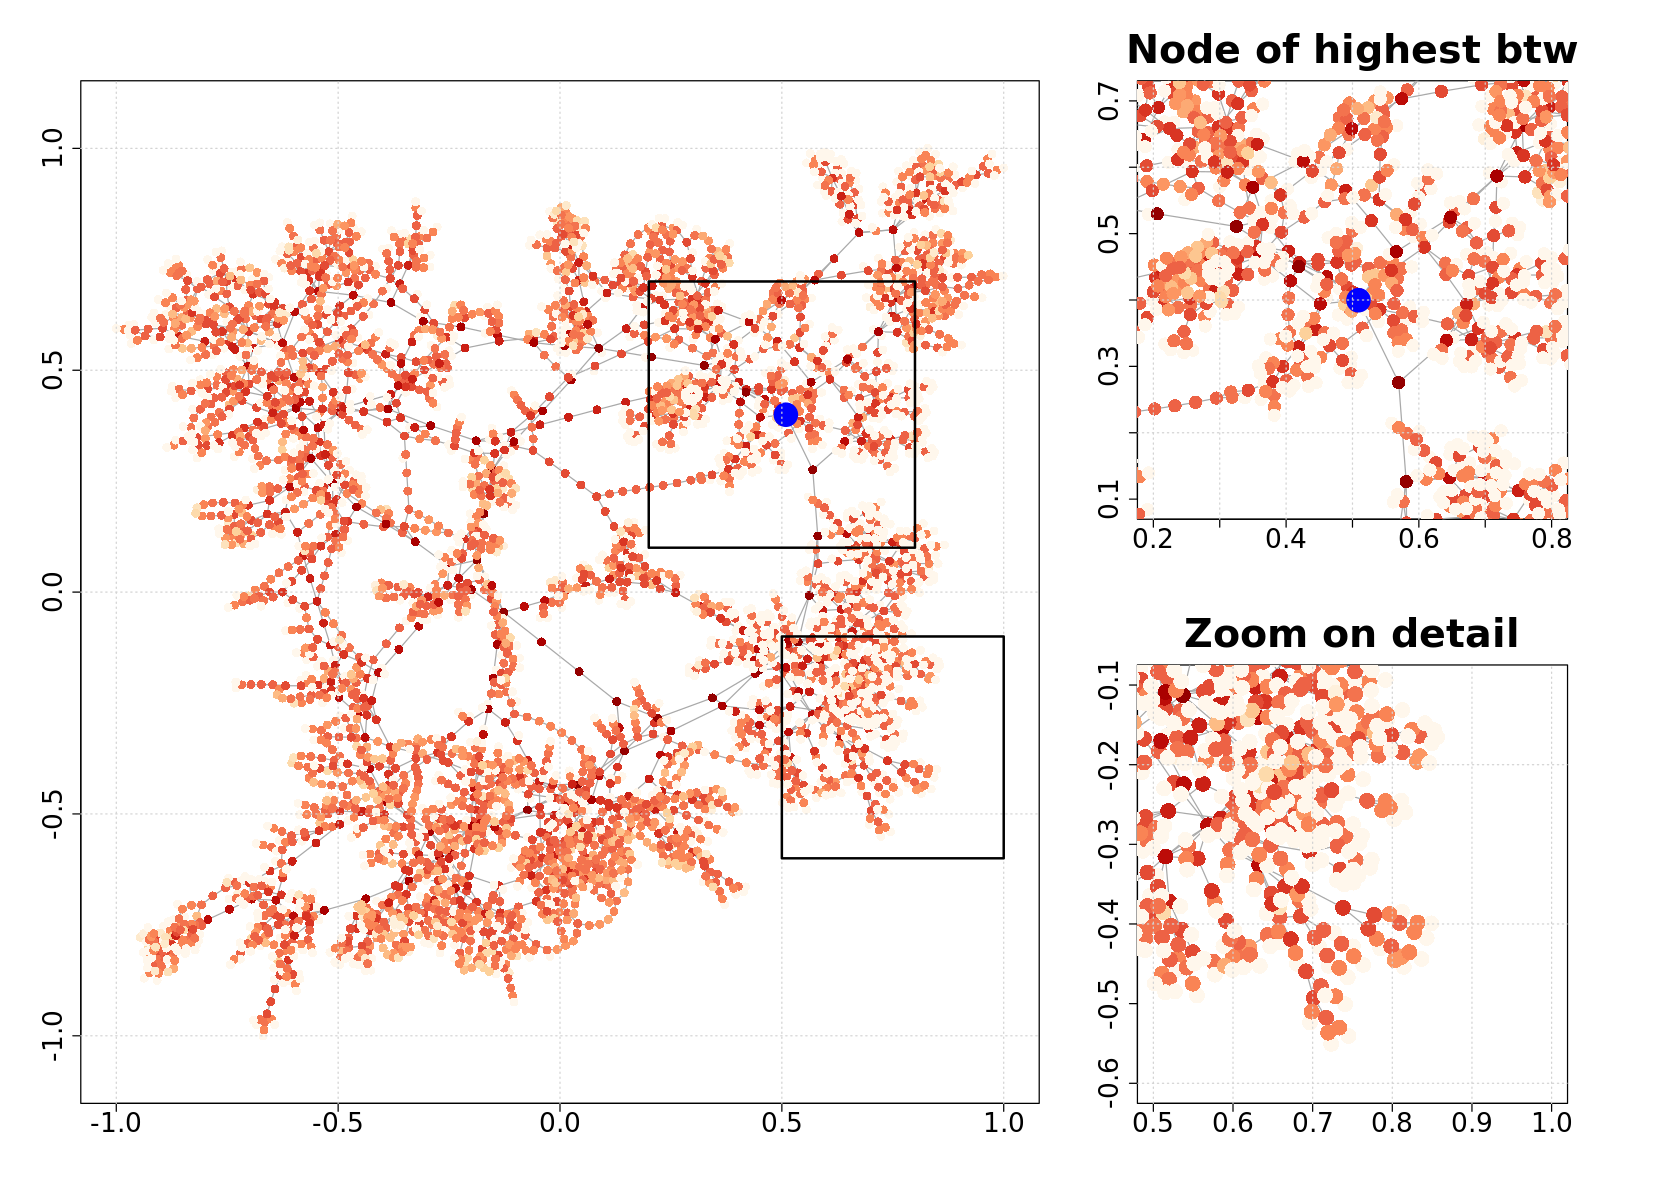

In [7]:
# pdf("power/whole_graph.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)

plot(g, layout = layout, 
     vertex.size = 2,
     vertex.frame.color = NA, 
     vertex.color = colors,
     vertex.label = "",
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     rescale=F )
points(layout[index,1],
       layout[index,2], 
       lwd=15, col='blue')
grid()
rect(xleft = 0.2, xright = 0.8, ytop = 0.7, ybottom = 0.1, lwd = 2)
rect(xleft = 0.5, xright = 1, ybottom = -0.6, ytop =-0.1, lwd = 2)


plot(g, layout = layout,
     vertex.size = 2,
     vertex.frame.color = NA,
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.1, 
     edge.arrow.size = 0,
     axes = T,main='Node of highest btw',
     xlim = c(0.2,0.8),
     ylim = c(0.1, 0.7),
     rescale=F, asp=1 )

points(layout[index,1],
       layout[index,2],
       lwd=15, col='blue')
grid()

plot(g, layout = layout, 
     vertex.size = 2, 
     vertex.frame.color = NA,
     vertex.color = colors,
     vertex.label = "",
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T, main='Zoom on detail',
     xlim = c(0.5,1),
     ylim = c(-0.6, -0.1),
     rescale=F, asp=1 )
grid()
# dev.off()

In [8]:
deg_graph<-degree(g)

fit_res<-fit_power_law(deg_graph, xmin = 1)

fit_res

f <- function(g, x) {
    function(x) {
        x^-g
    }
}

f2<-f(2)
f3<-f(3)
f_c<-f(fit_res$alpha)

$continuous
[1] FALSE

$alpha
[1] 1.795673

$xmin
[1] 1

$logLik
[1] -10258.33

$KS.stat
[1] 0.2813235

$KS.p
[1] 0

In [9]:
# get the prob of degreee distribution
p_not_log_grid <- data.frame(x = (min(degree(g)) - 1):max(degree(g)), y = ifelse(degree_distribution(g) ==
    0, NA, degree_distribution(g)))


# same thing but from the interenet network

nodes_in <- read.csv("internet/nodes_clean.csv")
edges_in <- read.csv("internet/edges.csv")

el_in <- as.matrix(edges_in + 1)
g_in <- graph_from_edgelist(el = el_in, directed = FALSE)

p_not_log_int <- data.frame(x = (min(degree(g_in)) - 1):max(degree(g_in)), y = ifelse(degree_distribution(g_in) ==
    0, NA, degree_distribution(g_in)))

pwr3 <- function(x) {
    return(x^(-3))
}
pwr2 <- function(x) {
    return(x^(-2))
}

In [10]:
# clean and merge the 2 datasets
p_not_log_grid['net']<-'US grid'
p_not_log_int['net']<-'Internet'

p_not_log_all<-rbind(p_not_log_grid, p_not_log_int)

Warning message in stat_function(fun = pwr2, color = "#FF0000", linewidth = 1, ylim = c(-3, :
“Ignoring unknown parameters: `ylim`”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1394 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 51 rows containing missing values (`geom_function()`).”
Warning message:
“Removed 36 rows containing missing values (`geom_function()`).”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”
Warning message in is.na(x):
“is.na() applied to non-(list or vector) of type 'expression'”


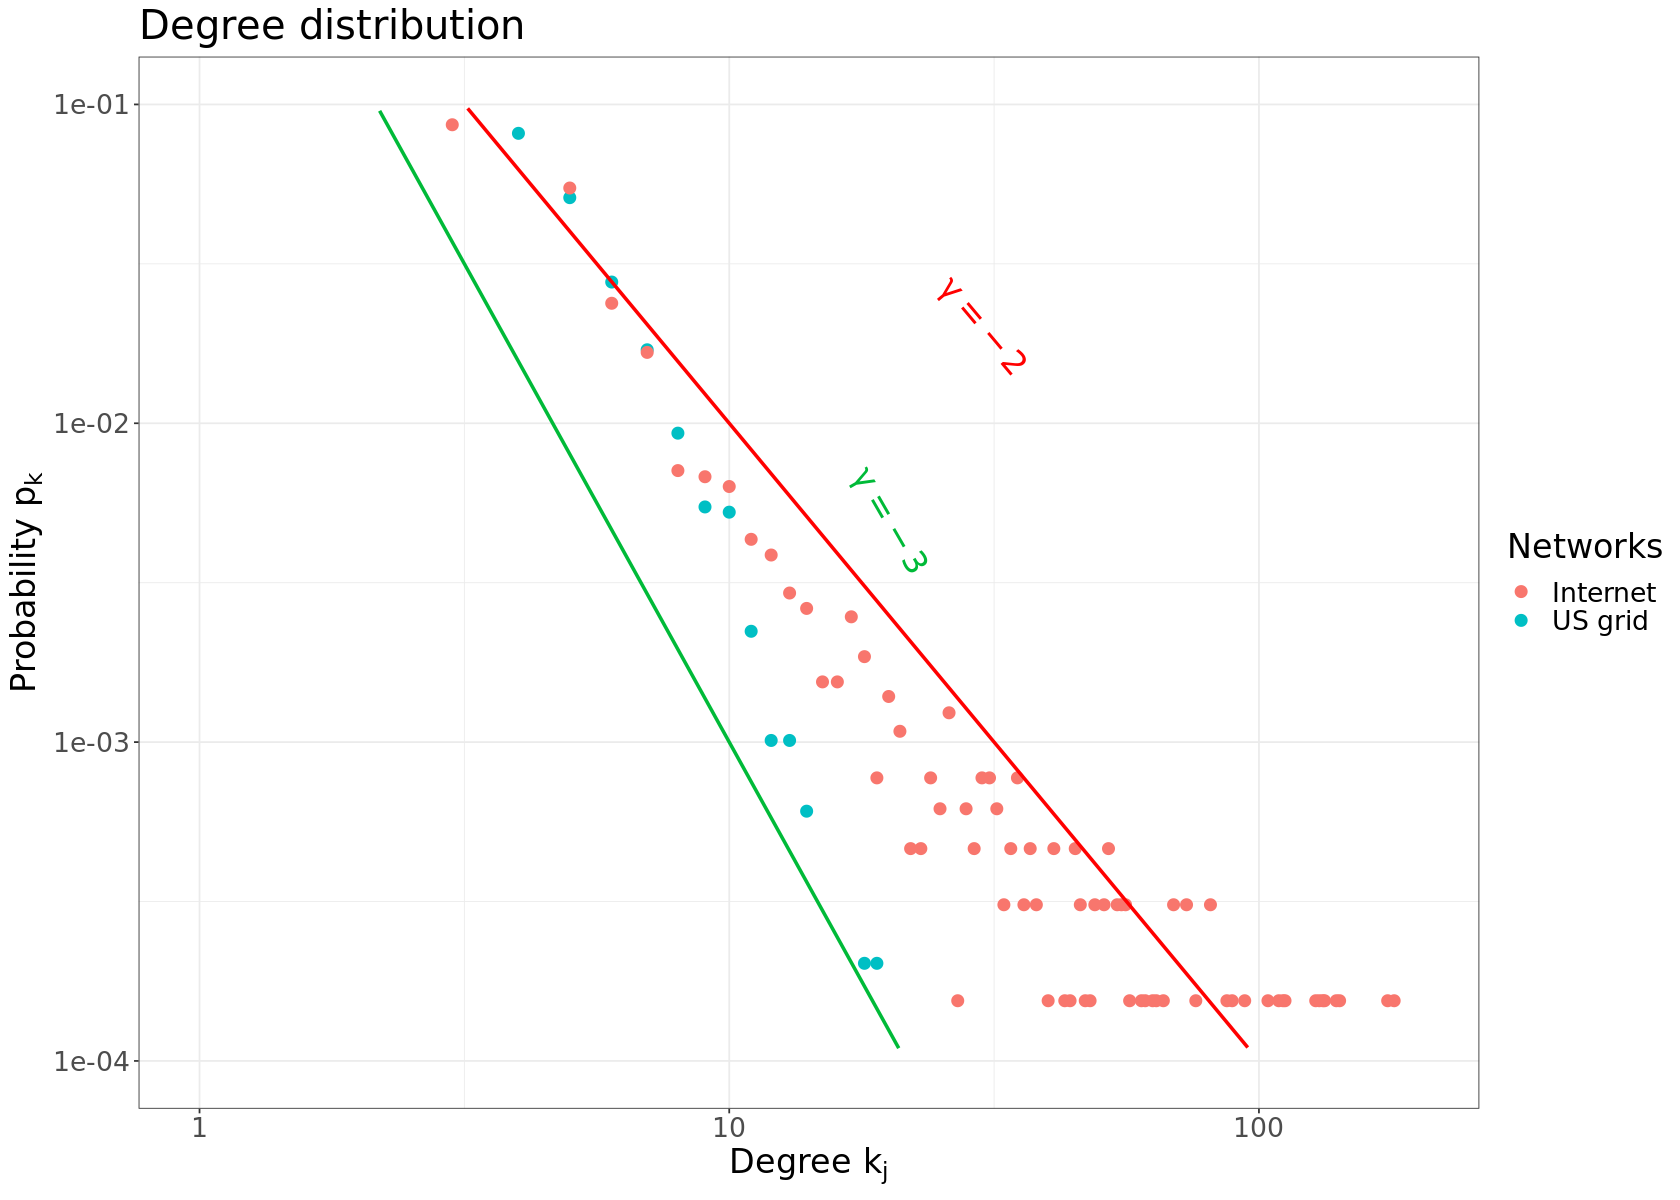

In [11]:
# plot nicely the degree distribution of the 2 different networks
plot_deg_dist_all<-ggplot(p_not_log_all) +
geom_point(aes(x = x, 
               y = y,
               col = net),
           size = 3) +
scale_x_log10(limits=c(1, 200)) +
scale_y_log10(limits=c(1e-4, 1e-1)) +
theme_bw() + 
theme(text = element_text(size = 20)) + 
labs(title = "Degree distribution",
     x = expression(paste("Degree ", k[j])),
     y = expression(paste("Probability ", p[k])),
     col = "Networks") +
stat_function(fun = pwr3,
              color = "#00BA38",
              linewidth = 1,
              xlim = c(0, 2))+
stat_function(fun = pwr2,
              color = "#FF0000",
              linewidth = 1,
              ylim = c(-3, -1))+
annotate(geom = "text",
         x = 20,
         y = 4.9e-3,
         label = expression(gamma == -3),
         color = "#00BA38",
         size = 7,
         angle = -60)+
annotate(geom = "text",
         x = 30,
         y = 2e-2,
         label = expression(gamma == -2),
         color = "#FF0000",
         size = 7,
         angle = -50)

plot_deg_dist_all

# ggsave(plot = plot_deg_dist_all, filename = 'internet/plot_deg_dist_all.pdf', width = 10, height = 7,
#     scale = 0.75)

In [12]:
# do the same comparison but with the betweennness
betwe_in <- betweenness(g_in, normalized = FALSE)

betwe_df_in <- data.frame(x = betwe_in)

betwe <- betweenness(g, normalized = FALSE)

betwe_df <- data.frame(x = betwe)

betwe_df_in["net"] <- "Internet"
betwe_df["net"] <- "US grid"
betwe_df_all <- rbind(betwe_df_in, betwe_df)

Warning message:
“`stat(density)` was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 5129 rows containing non-finite values (`stat_density()`).”


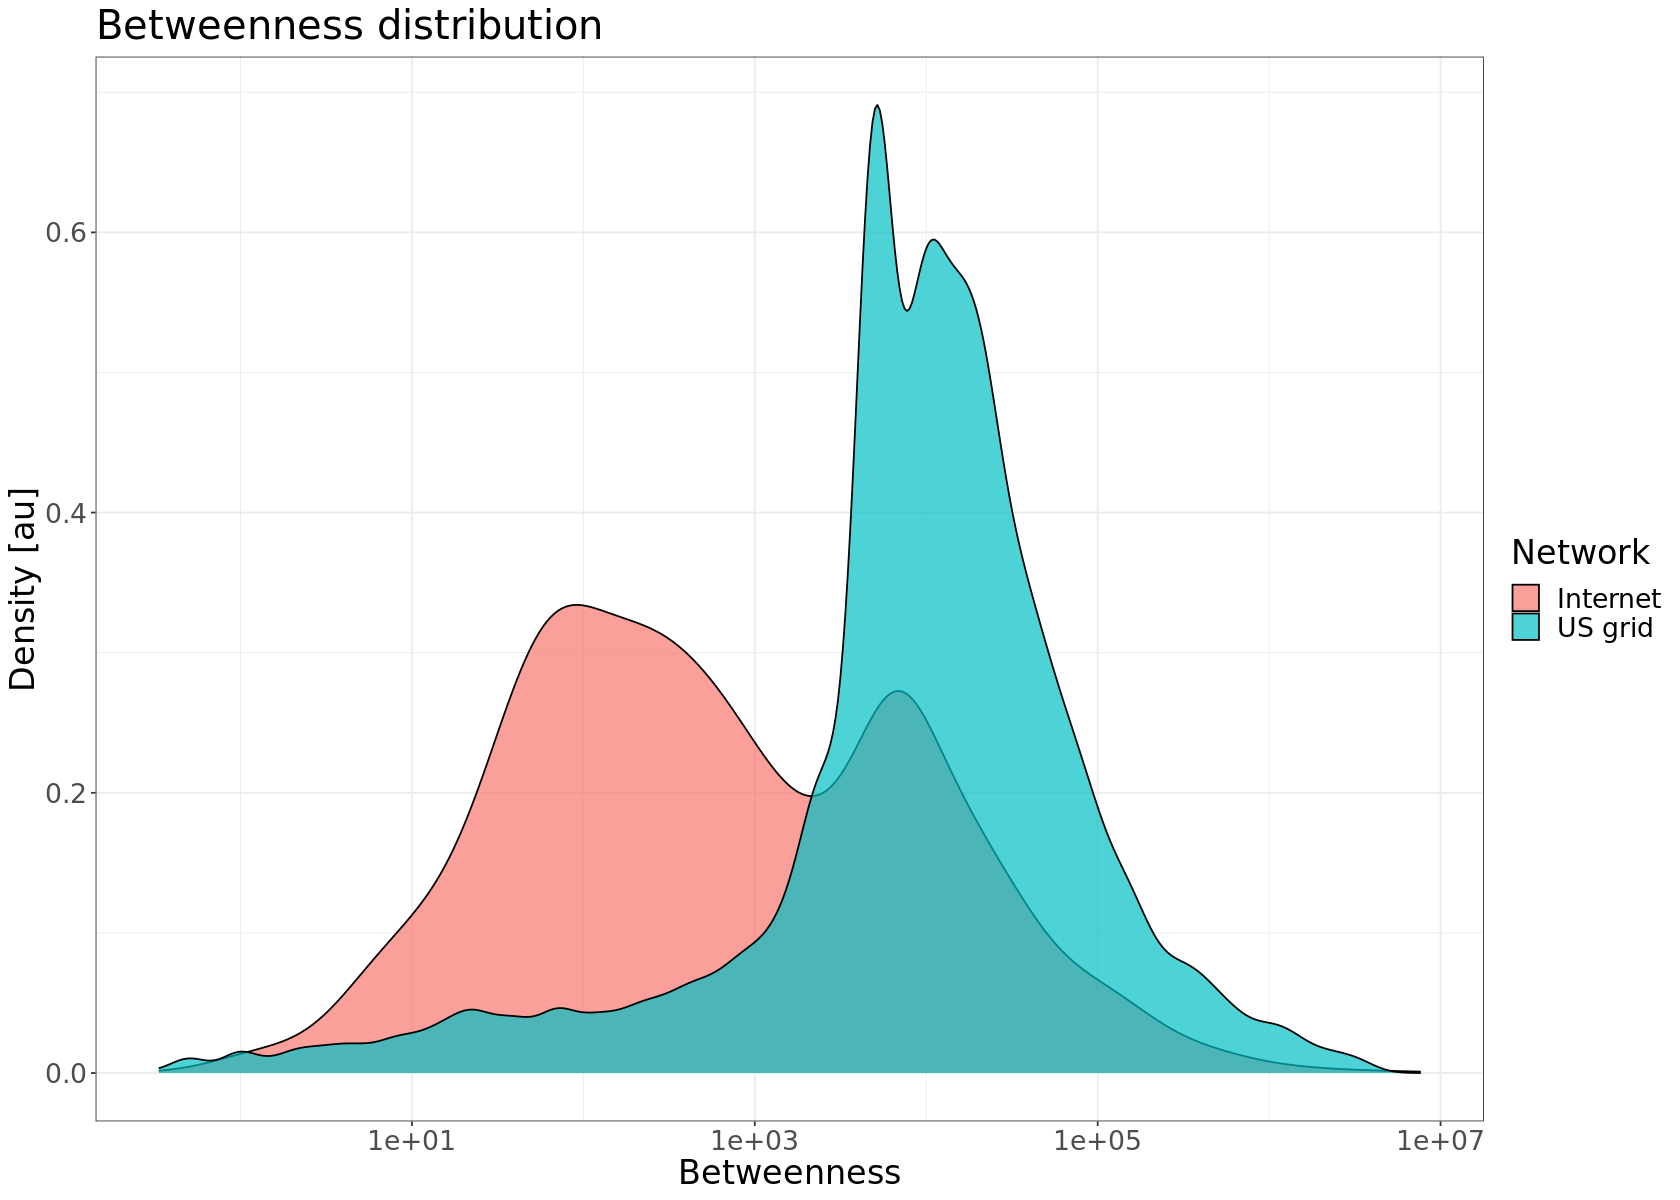

In [13]:
# plot
betw_plot_all <- ggplot(betwe_df_all) +
geom_density(aes(x = x,
                 y = stat(density),
                 fill = net),
             alpha = 0.7) +
scale_x_log10() +
theme_bw() +
theme(text = element_text(size = 20)) + 
labs(x = "Betweenness", y = "Density [au]",
     title = "Betweenness distribution", 
     fill = "Network")

betw_plot_all

# ggsave(plot = betw_plot_all, filename = "power/betweenness_plot_all.pdf", width = 10,
#     height = 7, scale = 0.75)

## Analysis of tear down at different $\alpha$
Refer to script for data generation

Here only the code for the graphs is shown

In [14]:
g_ratios<-read.csv('power/destroy_power_complete.csv')

Warning message:
“`position_dodge()` requires non-overlapping x intervals”
Warning message:
“Removed 15 rows containing missing values (`geom_segment()`).”


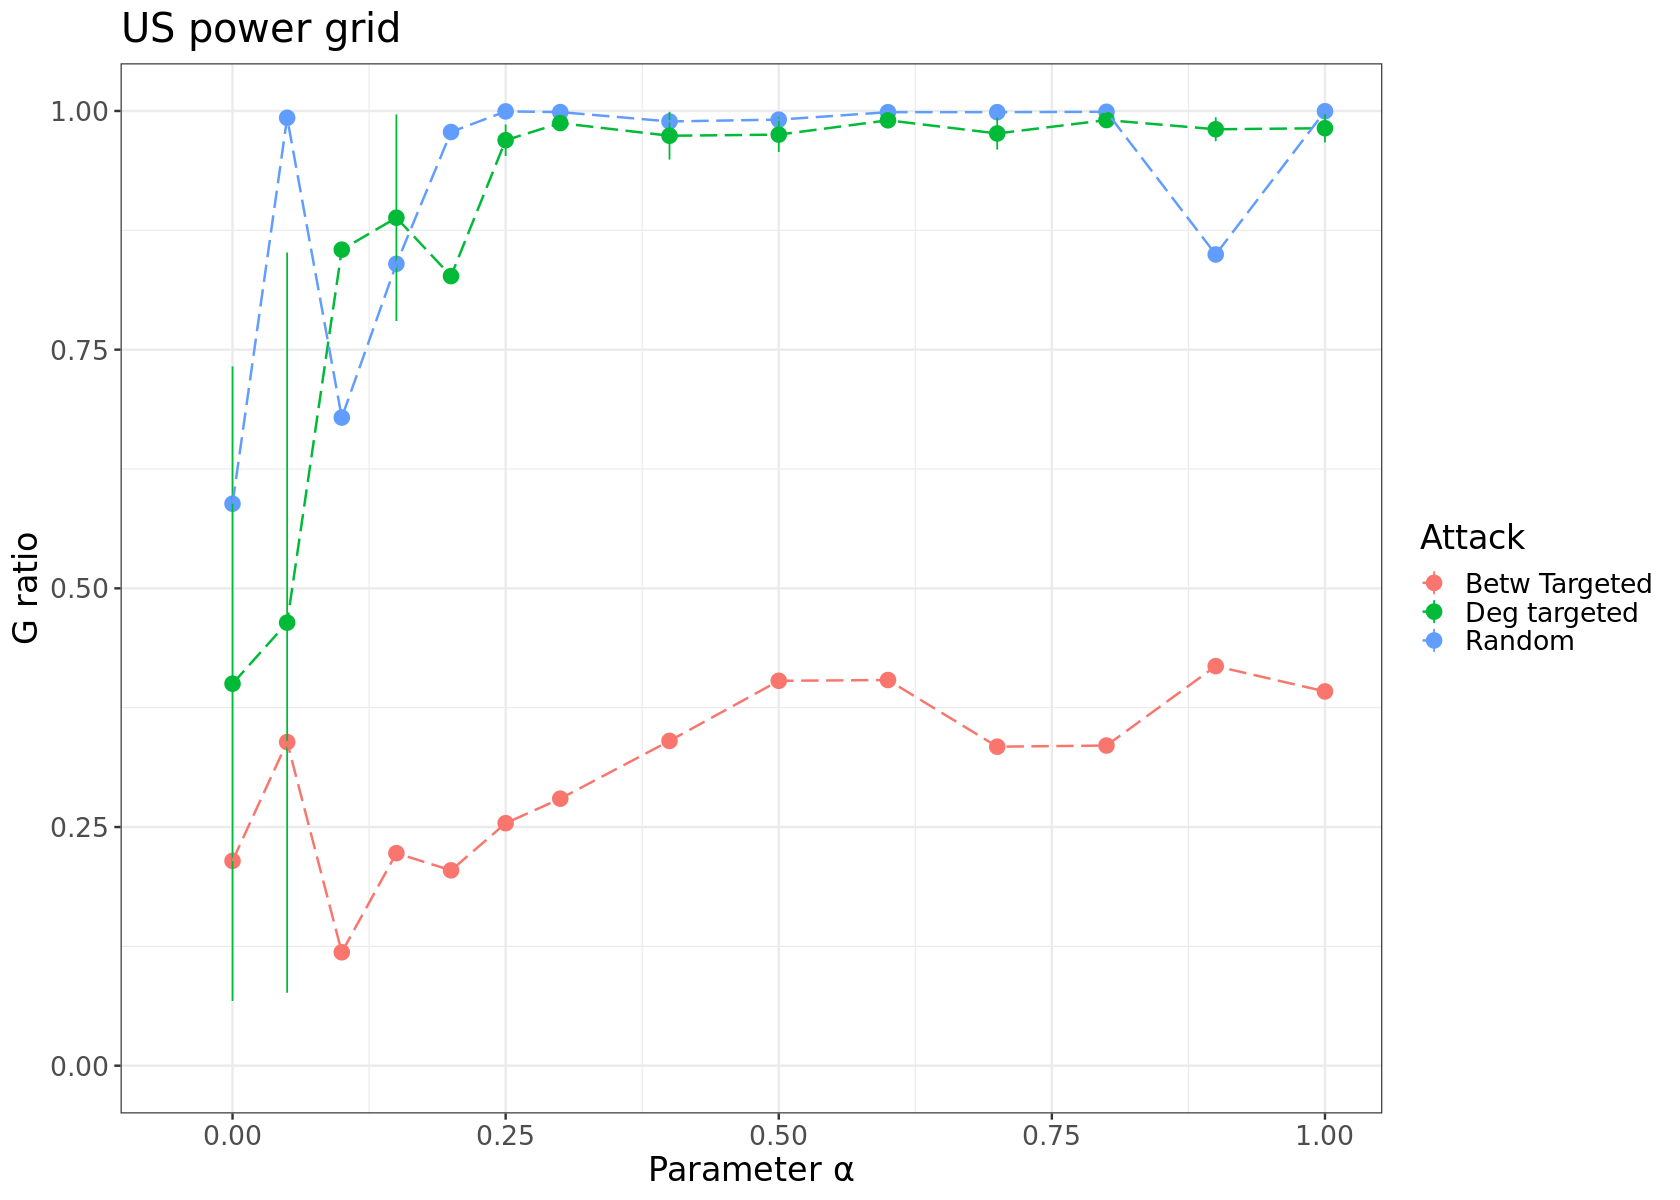

In [15]:
plot_conf_grd <- ggplot(g_ratios) +
geom_point(aes(x = alpha,
               y = g_ratio,
               col = type),
           size = 4) +
geom_linerange(aes(x = alpha,
                   ymax = g_ratio + g_ratio_sd,
                   ymin = g_ratio - g_ratio_sd,
                   col = type),
               position = position_dodge(-0.02)) +
geom_line(aes(x = alpha,
              y = g_ratio,
              col = type),
          linewidth = 0.7,
          linetype=5) +
scale_x_continuous(limits = c(-0.05, 1)) +
labs(x = expression(paste("Parameter ", alpha)), 
     y = "G ratio",
     col = "Attack", title='US power grid') +
ylim(0, 1) +
theme_bw(base_size = 15) +
theme( text = element_text(size = 20))


plot_conf_grd

# ggsave(plot = plot_conf_grd, filename = 'power/plot_g.pdf', width = 10, height = 7,
#     scale = 0.75)

## Detailed analysis for $\alpha=0.5$
Arbitrary choice to show what happens behind the curtain of the cascades failures

In [16]:
alpha<-1

In [17]:
V(g)$cst_ids <- 1:length(g)


V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

dead_nodes <- overloaded

g_or <- g

In [18]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

In [19]:
orig_idx<-V(g_or)[overloaded]$cst_ids

dead_nodes<-c(dead_nodes, orig_idx)

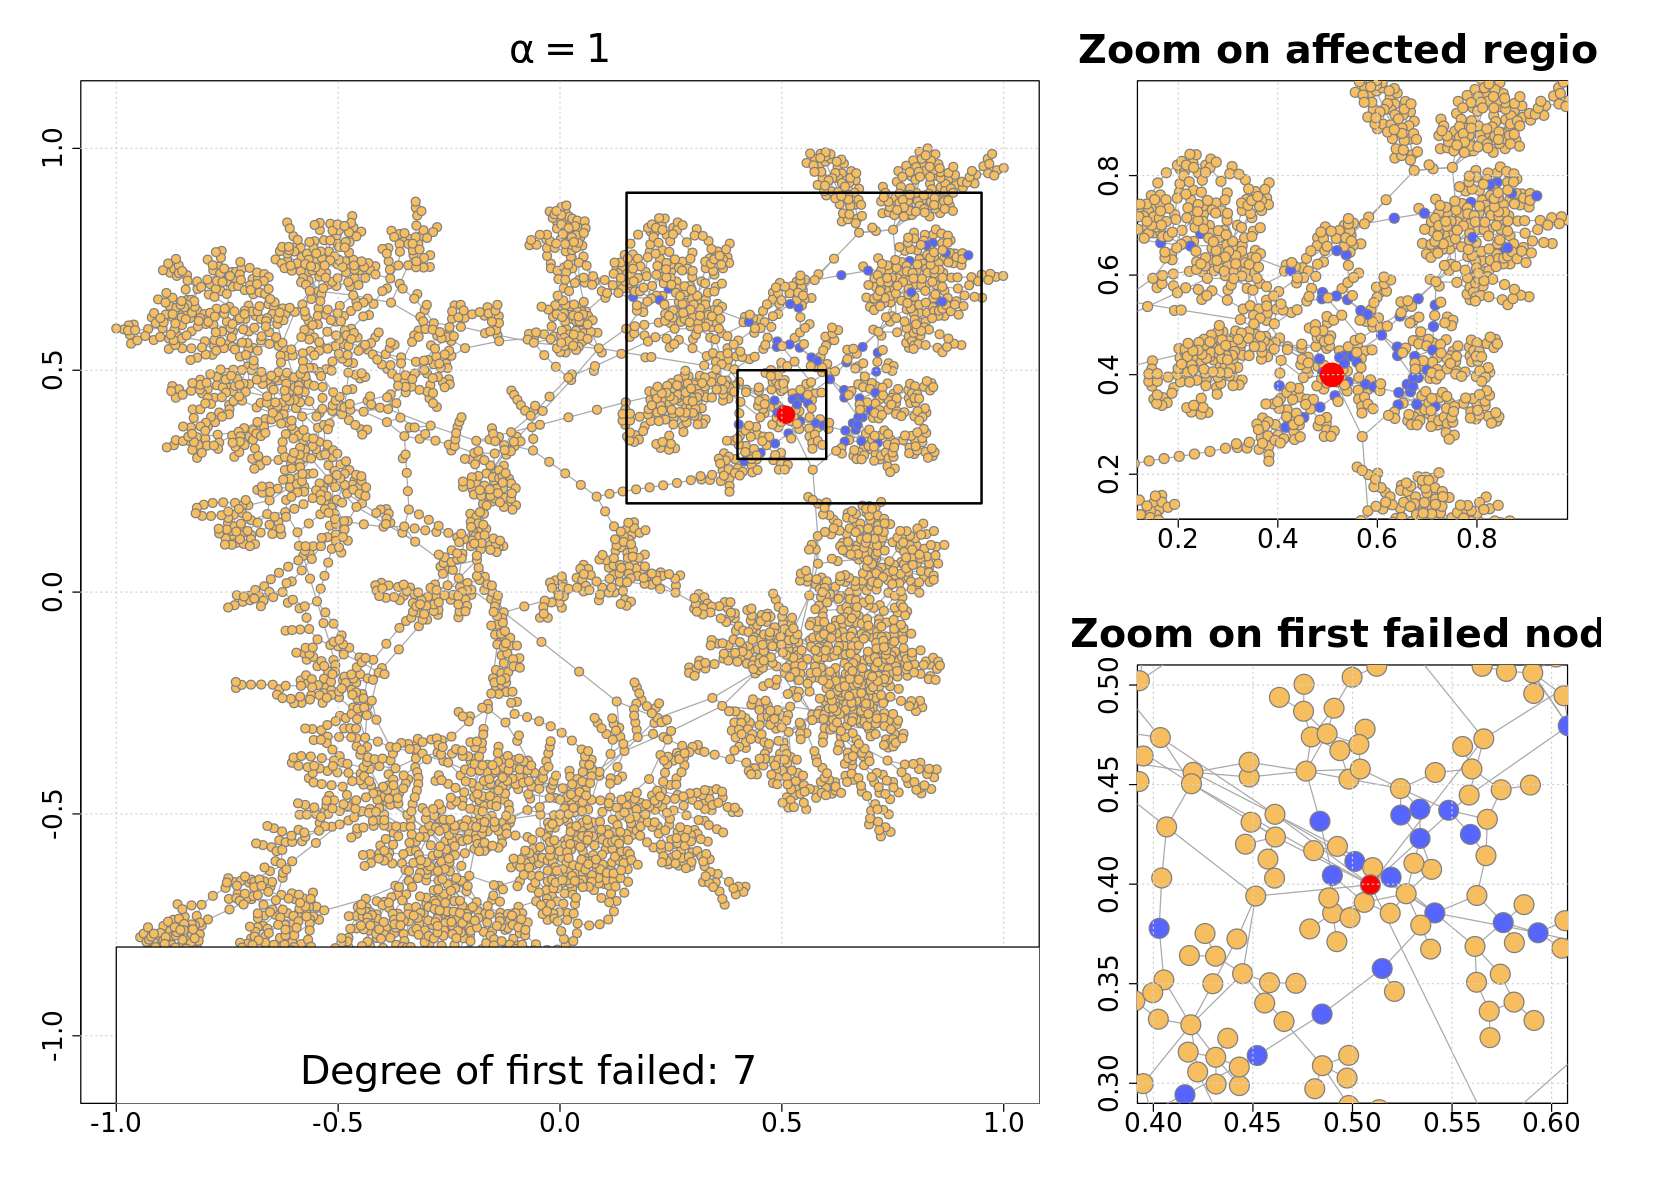

In [20]:
colors<-mypal[btw_col_idx]

colors[orig_idx]<-'#5765ff'
colors[-orig_idx]<-'#f7be60'
colors[index]<-'red'

# pdf("power/whole_graph_failing.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)
# layout.show(3)


x_left_1<-0.15
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<-0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout,
     vertex.size = 2,
     vertex.frame.color = 'grey50',
     vertex.color = colors,
     vertex.label = "",
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     main=expression(paste(alpha==1)),
     rescale=F )

points(layout[index,1],
       layout[index,2],
       lwd=10, col='red')

grid()
rect(xleft = x_left_1,
     xright = x_right_1,
     ytop = y_top_1,
     ybottom = y_bottom_1,
     lwd = 2)
rect(xleft = x_left_2,
     xright = x_right_2, 
     ybottom = y_bottom_2,
     ytop =y_top_2,
     lwd = 2)
legend(-1, -0.8,
       legend = c(paste("Degree of first failed:", degree(g)[index]),
                  paste("Affected nodes:",length(dead_nodes))), 
       bg='white', cex=3)

plot(g, layout = layout, 
     vertex.size = 2,
     vertex.frame.color = 'grey50',
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     main='Zoom on affected region',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F,
     asp=1 )
points(layout[index,1],
       layout[index,2],
       lwd=15, col='red')
grid()

plot(g, layout = layout,
     vertex.size = 1,
     vertex.frame.color = 'grey50',
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.5,
     edge.arrow.size = 0,
     axes = T, main='Zoom on first failed node',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2,y_top_2),
     rescale=F, asp=1 )

grid()
# dev.off()

In [21]:
# get non local effects for power grid network
# get distances of first failed from triggered node
first_faling <- data.frame(d = as.vector(distances(graph = g,
                                                   v = index, to = orig_idx)))
# get distances from triggered node and all the others
distances_from_failing_node <- data.frame(d = as.vector(distances(graph = g,
                                                                  v = index)))

In [22]:
# join datasets
distances_from_failing_node["type"] <- "between 1st and any node"
first_faling["type"] <- "between 1st and 2nd failed nodes"
dst_all <- rbind(distances_from_failing_node, first_faling)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


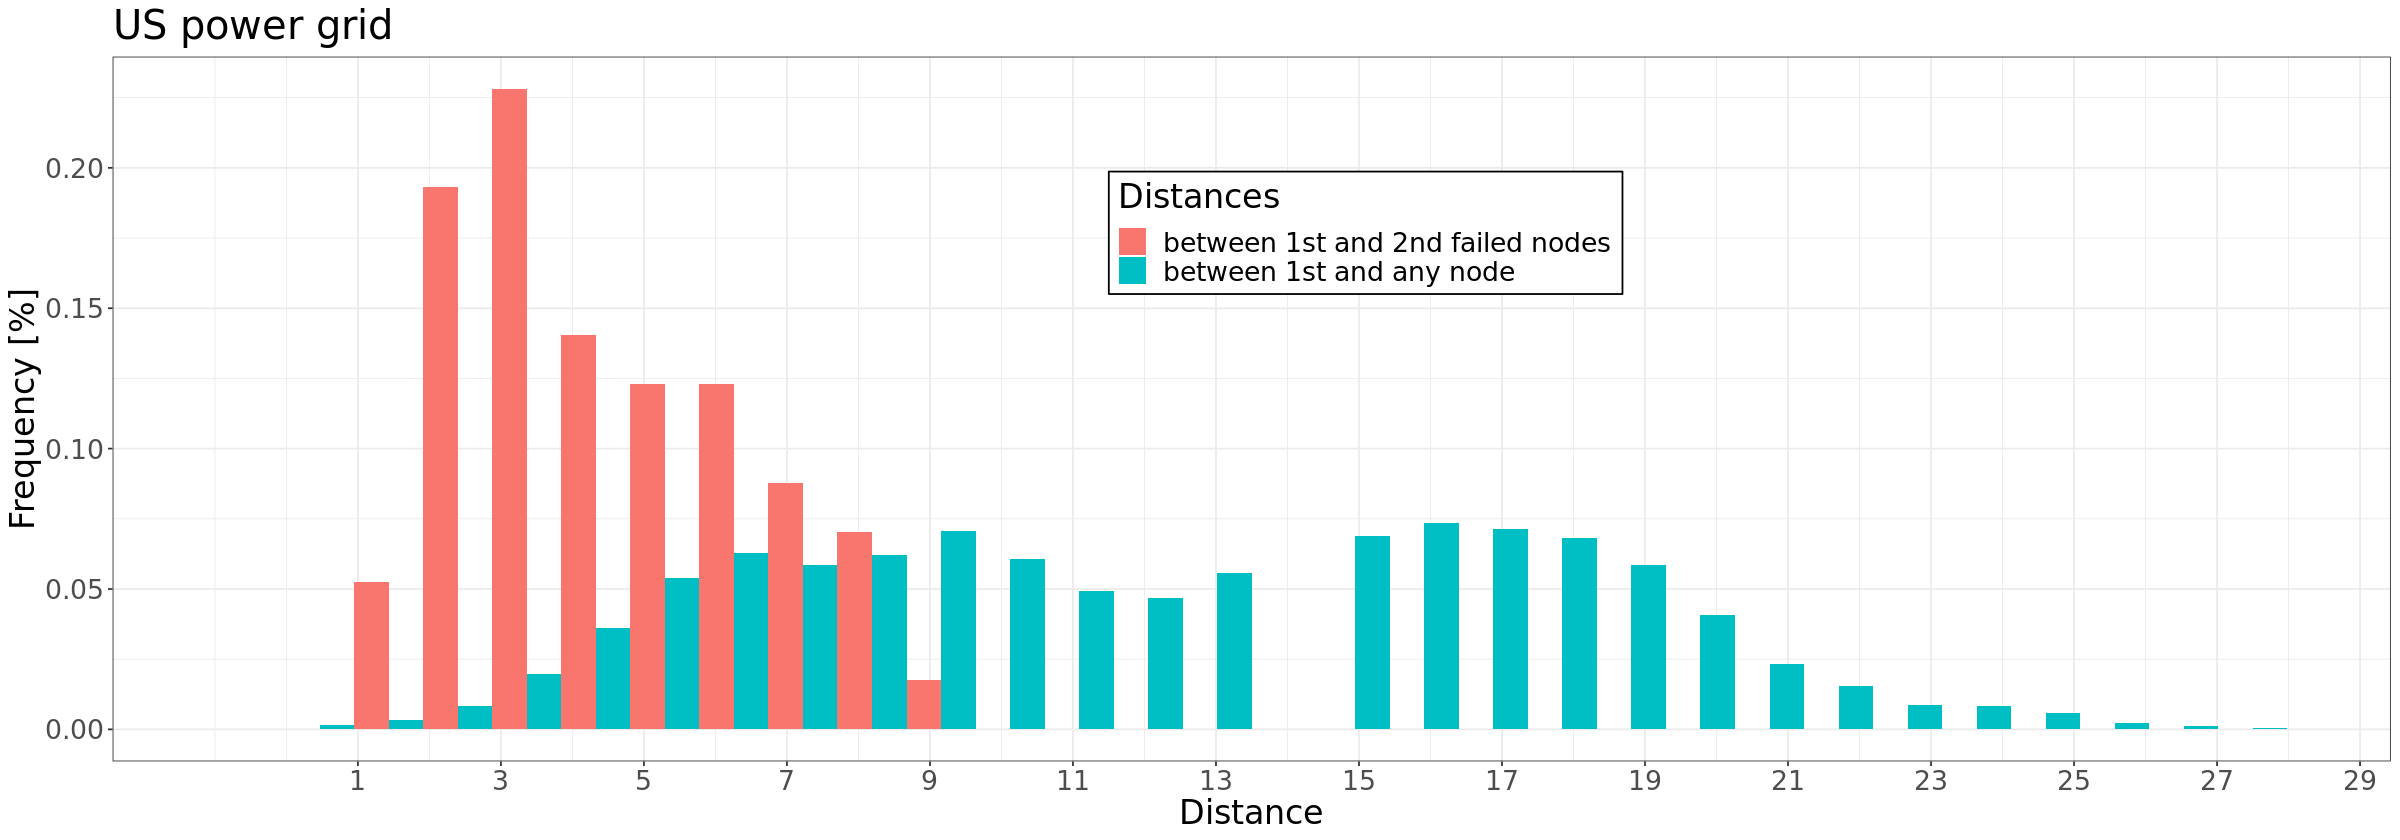

In [23]:
options(repr.plot.width = 20, repr.plot.height = 7)

plt_dst_all <- ggplot(dst_all) +
geom_histogram(aes(x = d,
                   y = ..density..,
                   fill = type),
               position = position_dodge()) + 
labs(x = "Distance",
     y = "Frequency [%]", 
     title = "US power grid",
     fill = "Distances") +
theme_bw() +
theme(text = element_text(size = 20)) + 
theme(legend.position = c(0.55, 0.75),
      legend.background = element_rect(size = 0.5, linetype = "solid", colour = "black")) +
scale_x_continuous(breaks = seq(1.5, 30.5, 2),
                   labels = seq(1, 30, 2))

plt_dst_all

# ggsave(plot = plt_dst_all, filename = "power/dst_all_first_failed.pdf", width = 10,
#     height = 7, scale = 0.75)

In [24]:
g_or <- delete_vertices(g_or, overloaded)
V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
overloaded <- as.vector(V(g_or)[load > capacity])

orig_idx<-V(g_or)[overloaded]$cst_ids


dead_nodes<-c(dead_nodes, orig_idx)

In [25]:
V(g)$load <- betweenness(g, v = V(g), directed = FALSE)
V(g)$capacity <- (1 + alpha) * V(g)$load
overloaded <- order(V(g)$load, decreasing = TRUE)[1]

dead_nodes<-overloaded
g_or <- g

counts<-0
while (length(overloaded) > 0) {
    g_or <- delete_vertices(g_or, overloaded)
    V(g_or)$load <- betweenness(g_or, v = V(g_or), directed = FALSE)
    overloaded <- as.vector(V(g_or)[load > capacity])
    orig_idx<-V(g_or)[overloaded]$cst_ids
    dead_nodes<-c(dead_nodes, orig_idx)
    counts<-counts+1
}


n_prime <- max(components(g_or)$csize)
n_orig <- max(components(g)$csize)

# return(n_prime/n_orig)

In [26]:
biggest_cluster_id <- which.max(components(g_or)$csize)

# get largest component noeds ids
vert_ids <- V(g_or)[components(g_or)$membership == biggest_cluster_id]

llc_id<-V(g_or)[vert_ids]$cst_ids

In [27]:
# do the fancy coloring
colors[dead_nodes]<-'#5765ff'
colors[-dead_nodes]<-'#f7be60'
colors[index]<-'red'
colors[llc_id]<-'#11d417'

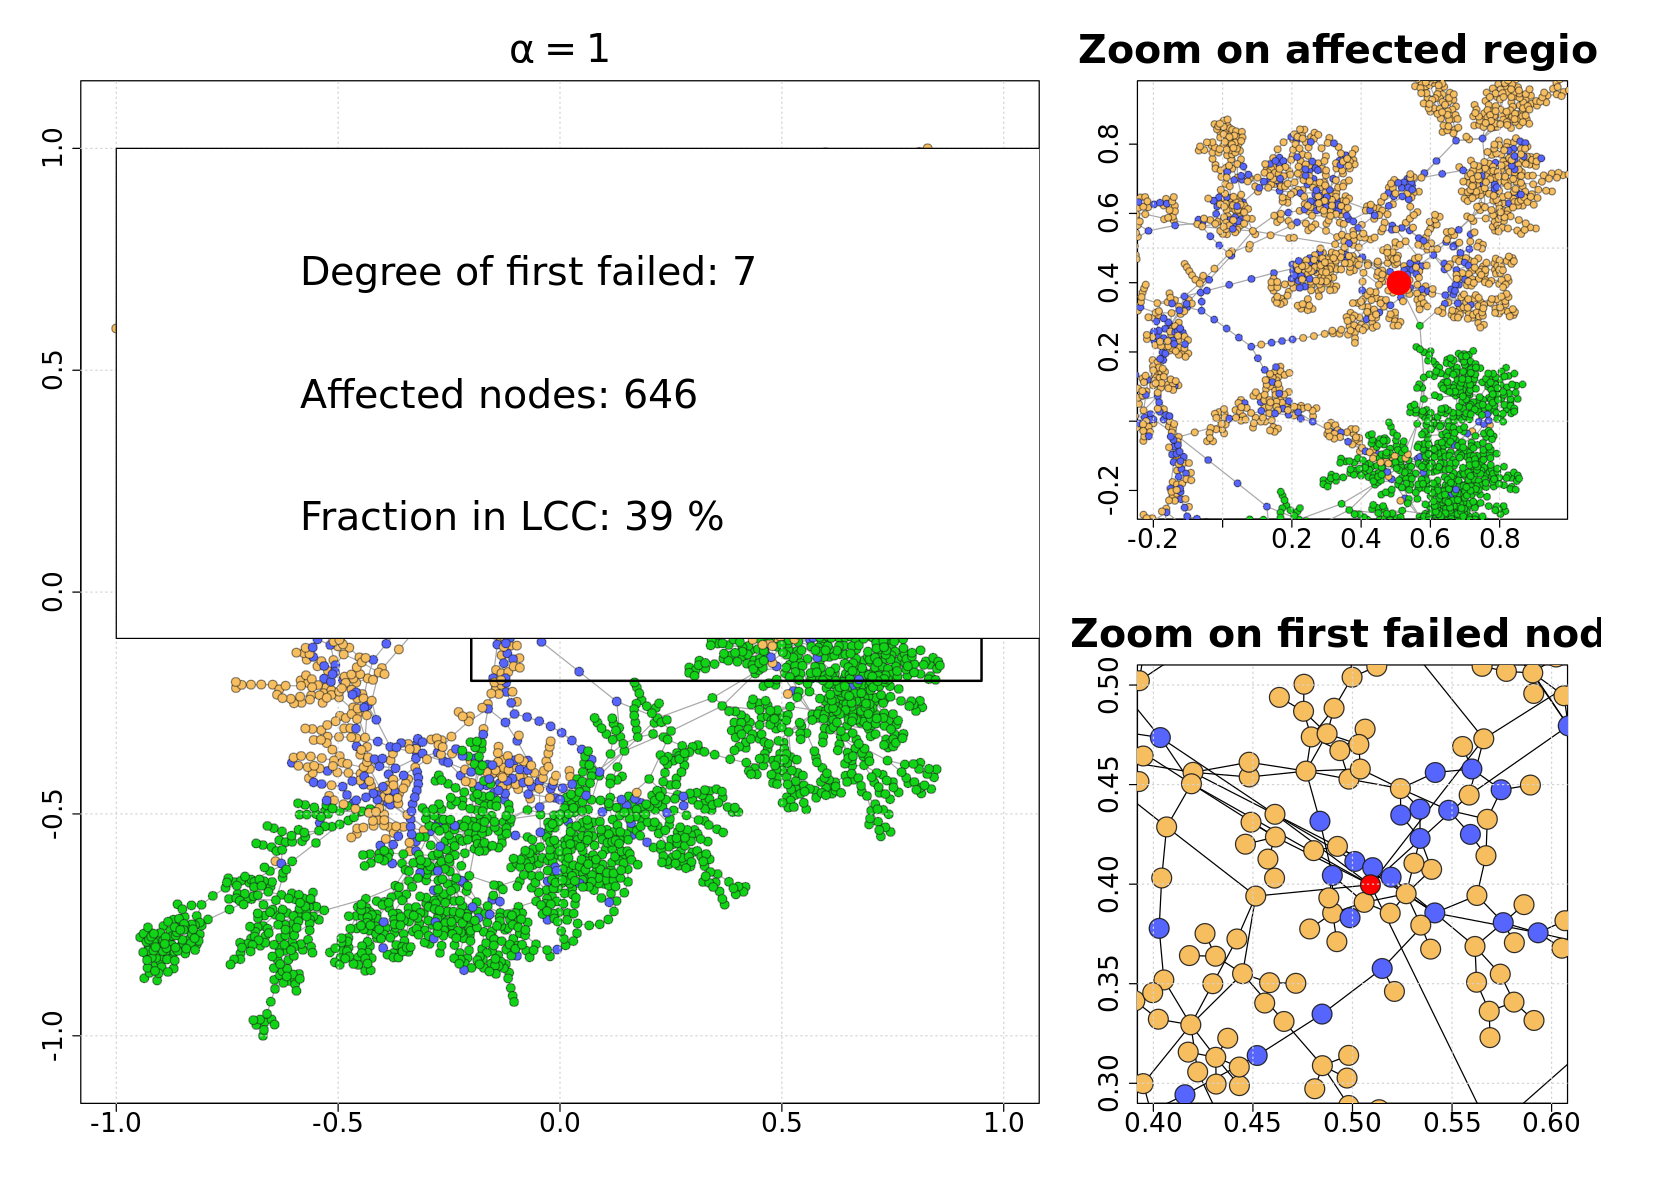

In [28]:
# pdf("power/whole_graph_failing_all.pdf",width=14, height = 10) 
options(repr.plot.width=14, repr.plot.height=10)
par(cex.axis=2, cex.lab = 4, cex.main=3, oma=c(1,1,1,5))
layout.matrix <- matrix(c(1, 1, 1, 1, 2, 3), nrow = 2, ncol = 3)
lay_plots<-layout(mat = layout.matrix)

x_left_1<--0.2
x_right_1<-0.95
y_top_1<-0.9
y_bottom_1<--0.2

x_left_2<-0.4
x_right_2<-0.6
y_top_2<-0.5
y_bottom_2<-0.3

plot(g, layout = layout, 
     vertex.size = 2,
     vertex.frame.color =alpha('grey10',0.5),
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,
     main=expression(paste(alpha==1)),
     rescale=F )

points(layout[index,1],
       layout[index,2],
       lwd=10, col='red')
grid()
rect(xleft = x_left_1, xright = x_right_1, ytop = y_top_1, ybottom = y_bottom_1, lwd = 2)
rect(xleft = x_left_2, xright = x_right_2, ybottom = y_bottom_2, ytop =y_top_2, lwd = 2)
legend(-1, 1, legend = c(paste("Degree of first failed:", degree(g)[index]),
                         paste("Affected nodes:",length(dead_nodes)),
                         paste('Fraction in LCC:', round(n_prime/n_orig,2)*100, '%')),
       bg='white', cex=3)

plot(g, layout = layout,
     vertex.size = 2,
     vertex.frame.color = alpha('grey10',0.5),
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.1,
     edge.arrow.size = 0,
     axes = T,main='Zoom on affected region',
     xlim = c(x_left_1,x_right_1),
     ylim = c(y_bottom_1, y_top_1),
     rescale=F, asp=1 )

points(layout[index,1], layout[index,2], lwd=15, col='red')
grid()

plot(g, layout = layout,
     vertex.size = 1,
     vertex.frame.color = alpha('grey10',0.9),
     vertex.color = colors,
     vertex.label = "", 
     edge.size = 0.5,
     edge.arrow.size = 0,
     edge.color='black',
     axes = T, main='Zoom on first failed node',
     xlim = c(x_left_2,x_right_2),
     ylim = c(y_bottom_2, y_top_2),
     rescale=F, asp=1 )

grid()
# dev.off()